## N-body graph networks for Peter W. Battaglia et. al, 2016

TO DO LIST

One thing you might want to do with the bowtie plot analysis is just fit a linear regression, with the e vectors as predictors and true forces as targets, to quantify what the bowtie plots show. If it's a perfect linear fit, that's interesting.

You could also try replacing the node update model with an integrator (eg. RK4), because then the messages should be learned without the rotation. Since integration is a pretty safe assumption in modeling dynamical systems, this seems like a reasonable choice.

As for the presentation, you might want to start with the bowtie/true comparison first, then go to the symbolic regression as a "now that we've verified it can learn stuff we already know about, how could it discover new symbolic knowledge?". 

I'm wondering: if you plug in the discovered symbolic function in the graph net, rather than an MLP, how do the trajectories look? (Your MSEs in Table 1 are on 1-step predictions right?)

I'm also curious about what happens in 3D, or with other physical systems, eg. mass spring, charged particles, etc.


In [4]:
import sys
import warnings
import math, copy
import numpy as np
import tensorflow as tf
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
warnings.filterwarnings("ignore") 

In [5]:
config = tf.ConfigProto(log_device_placement=True)
config.gpu_options.allow_growth = True

In [6]:
# Simulation parameters
Nt = 1000 #  number of time steps
G = 1 # gravitational constaNt
Dt = 0.01 # time step

# Graph network parameters
Ds = 5 # number of features [mass, x, y, vx, vy]
No = 6 # number of objects
Nr = No*(No-1) # number of relations
Dr = 1 # relationship dimension
Dx = 1 # external effect dimension
Dp = 2 # object modeling output dimension

# Variable
cube = False # True for 3D simulations
inv = False  # True for testing F ~ 1/r laws
De = 2 # effect dimension
LABEL_MAGIC = 1000

In [7]:
# Nbody Simulation System
def cal_force(reciever,sender):
    """ calculate force between two objects
    """
    diff = sender[1:3]-reciever[1:3]
    dist = np.sqrt(np.sum(diff**2))
    too_close = dist < 0.05
    if not too_close:
        if not cube:
            if not inv:
                return G*reciever[0]*sender[0]/(dist**3)*diff, True
            else:
                return G*reciever[0]*sender[0]/(dist**2)*diff, True
        else:
            return G*reciever[0]*sender[0]/(dist**4)*diff, True
    else:
        return - 100, False

def next_step(cur_state,n_body):
    """ update positions & velocities after Dt
    """
    next_state = np.zeros((n_body,Ds),dtype=float)
    for i in range(n_body):
        force = 0.0
        for j in range(n_body):
            if j==i:
                continue
            added_force, good_force = cal_force(cur_state[i], cur_state[j]) 
            if not good_force:
                return None
            force += added_force
        acc = force/cur_state[i][0]
        next_state[i][0] = cur_state[i][0];
        next_state[i][3:5] = cur_state[i][3:5]+acc*Dt; #New velocity
        next_state[i][1:3] = cur_state[i][1:3]+next_state[i][3:5]*Dt; #New position
    return next_state;

def get_simulation(n_body, set_num=100, recursion=0, verbose=False):
    """ generate a n-body simulation
    """
    if recursion > 100:
        return None
    try:
        data = np.zeros((Nt,n_body,Ds),dtype=float)
        data[0][0] = [np.random.rand()*3 + 3.0, 0, 0, 0, 0.]
        for i in range(1,n_body):
            data[0][i][0] = np.random.rand()*1+1.0 #Mass
            dist = np.random.rand()*5.0 + 5#Distance
            theta_rad = math.radians(np.random.rand()*360.)
            data[0][i][1] = dist*np.cos(theta_rad)
            data[0][i][2] = dist*np.sin(theta_rad)
            data[0][i][3] = -np.sin(theta_rad)*np.sqrt(G*(data[0][0][0]+data[0][i][0])/dist)
            data[0][i][4] = np.cos(theta_rad)*np.sqrt(G*(data[0][0][0]+data[0][i][0])/dist)
        for i in range(1,Nt):
            new_data = next_step(data[i-1],n_body);
            if new_data is None:
                break
            data[i] = new_data
        else:
            # Good integration
            if verbose:
                print("Took", recursion, "iterations")
            return data
        return simulation(n_body, recursion+1, verbose=verbose) # Re-run!
    except:
        return simulation(n_body, recursion+1, verbose=verbose) # Re-run!

In [ ]:
set_num = 1000
train_data = np.zeros(((Nt-1)*set_num, Ds, No), dtype=np.float32)
train_label = np.zeros(((Nt-1)*set_num, Dp, No), dtype=np.float32)
all_sims = gen_simulations(No, set_num)
for i in range(set_num):
    raw_data = all_sims[i]
    data = np.zeros((Nt-1, Ds, No), dtype=np.float32)
    label = np.zeros((Nt-1, Dp, No), dtype=np.float32)
    for j in range(Nt-1):
        data[j] = np.transpose(raw_data[j])
        label[j] = np.transpose(raw_data[j+1,:, 3:5] - raw_data[j,:, 3:5])
    train_data[i*(Nt-1):(i+1)*(Nt-1),:] = data
    train_label[i*(Nt-1):(i+1)*(Nt-1),:] = label
pkl.dump( {'train_data':train_data, 'test_data':train_label,
         'Nt': Nt, 'No': No},
        open('nbody_%d_bodies_%d.pkl'%(No, save_id), 'wb'))

In [8]:
def m(O,Rr,Rs,Ra):
    """ Marshalling function, rearranges the objects and relations into
    interaction terms.
    Output dimension: (2*Ds + Dr)*Nr
    """
    return tf.concat([tf.matmul(O,Rr), tf.matmul(O,Rs), Ra],1)

def phi_R(B, prob):
    """ B is input to phi_R, which applies an MLP to each column.
    Output is a distributed represeNtation of the relation with size De.
    Ouput dimension: De * Nr
    """
    B_trans = tf.transpose(B, [0, 2, 1])
    B_trans = tf.reshape(B_trans, [-1, 2*Ds+Dr])
    
    h_size = 100
    w1 = tf.Variable(tf.truncated_normal([2*Ds+Dr, h_size], stddev=0.1, name='phir_w1'), dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32, name='phir_b1')
    h1 = tf.nn.relu(tf.nn.dropout(tf.matmul(B_trans, w1) + b1, rate=prob))
    
    w2 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32, name='phir_w2')
    b2 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32, name='phir_b2')
    h2 = tf.nn.relu(tf.nn.dropout(tf.matmul(h1, w2) + b2, rate=prob))
    
    w3 = tf.Variable(tf.truncated_normal([h_size, h_size], stddev=0.1), dtype=tf.float32, name='phir_w3')
    b3 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32, name='phir_b3')
    h3 = tf.nn.relu(tf.nn.dropout(tf.matmul(h2, w3) + b3, rate=prob))
    
    w4 = tf.Variable(tf.truncated_normal([h_size, De], stddev=0.1), dtype=tf.float32, name='phir_w4')
    b4 = tf.Variable(tf.zeros([De]), dtype=tf.float32, name='phir_b4')
    h4 = tf.matmul(h3, w4) + b4
    
    h4_trans = tf.reshape(h4, [-1, Nr, De])
    h4_trans = tf.transpose(h4_trans,[0,2,1])
    return h4_trans

def a(O, Rr, X, E):
    """ Aggregation function: collects all effects that apply to each receiver
    object, merges them, and combine them with O and X to form a set of object model 
    inputs, one per object. No columns represeNt the object states, external effects, 
    and per-object aggregate iNteraction effects.
    Output dimension: C = (Ds+Dx+De)*No
    """
    E_bar = tf.matmul(E, tf.transpose(Rr, [0,2,1]))
    O_2 = tf.stack(tf.unstack(O, Ds, 1)[3:5],1)
    return tf.concat([O_2,X,E_bar],1)

def phi_O(C):
    """C applies to another MLP, to each of the No columns.
    Output size: Dp.
    """
    C_trans=tf.transpose(C,[0,2,1]);
    C_trans=tf.reshape(C_trans,[-1,2+Dx+De])
    
    h_size = 100
    w1 = tf.Variable(tf.truncated_normal([2+Dx+De, h_size], stddev=0.1), dtype=tf.float32)
    b1 = tf.Variable(tf.zeros([h_size]), dtype=tf.float32)
    h1 = tf.nn.relu(tf.matmul(C_trans, w1) + b1)
    
    w2 = tf.Variable(tf.truncated_normal([h_size,Dp], stddev=0.1), dtype=tf.float32)
    b2 = tf.Variable(tf.zeros([Dp]), dtype=tf.float32)
    h2 = tf.matmul(h1, w2) + b2
    
    h2_trans=tf.reshape(h2,[-1, No, Dp])
    h2_trans=tf.transpose(h2_trans,[0,2,1])
    return h2_trans


In [9]:
# Object Matrix
O = tf.placeholder(tf.float32, [None, Ds, No], name='O')

prob = tf.placeholder(tf.float32, shape=(), name='prob') #Turn off during eval

# Relation Matrics R=<Rr,Rs,Ra>
Rr = tf.placeholder(tf.float32, [None, No, Nr], name='Rr')
Rs = tf.placeholder(tf.float32, [None, No, Nr], name='Rs')
Ra = tf.placeholder(tf.float32, [None, Dr, Nr], name='Ra')

# next velocities
P_label = tf.placeholder(tf.float32, [None, Dp, No], name='P_label')

# External Effects
X = tf.placeholder(tf.float32, [None, Dx, No], name='X')

# marshalling function, m(G)=B, G=<O,R>  
B = m(O, Rr, Rs, Ra)

# relational modeling phi_R(B)=E
E = phi_R(B, prob)

# aggregator
C = a(O, Rr, X, E)

# object modeling phi_O(C)=P
P = phi_O(C)

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# loss function and optimizer
optimizer = tf.train.AdamOptimizer(0.001)
mse = tf.reduce_mean(tf.reduce_mean(tf.abs(P-P_label), [1,2])) 
trainer = optimizer.minimize(mse)

# Training
sess = tf.InteractiveSession(config=config)
init_op = tf.global_variables_initializer()

# Add ops to save and restore all the variables.
saver = tf.train.Saver()

#Run global variables
init_op.run()

train_losses = []
validation_losses = []

Instructions for updating:
Use tf.cast instead.


In [11]:
# Set up mini-batch for Rr_data, Rs_data, Ra_data and X_data
mini_batch = 100
Rr_batch = np.zeros((mini_batch, No, Nr), dtype=float)
Rs_batch = np.zeros((mini_batch, No, Nr), dtype=float)
Ra_batch = np.zeros((mini_batch, Dr, Nr), dtype=float) 
X_batch = np.zeros((mini_batch, Dx, No), dtype=float)

# add relations for different nodes
count = 0
for i in range(No):
    for j in range(No):
        if i==j: continue
        Rr_batch[:, i, count] = 1.0
        Rs_batch[:, j, count] = 1.0
        count += 1

In [12]:
# Data Preparation for graph-net
idx = 0
data = pkl.load(open('nbody_%d_bodies_%d.pkl' % (No, idx), 'rb'))
train_data = data['train_data']
train_label = data['test_data'] 
tr_data, tr_label  = train_data[:len(train_data)*4//5].copy(), train_label[:len(train_data)*4//5].copy()
val_data, val_label = train_data[len(train_data)*4//5:].copy(), train_label[len(train_data)*4//5:].copy()
tr_data_idx = np.arange(len(tr_data))

In [13]:
for epoch in range(2):
    # training
    tr_loss = 0
    num_tr = 0
    np.random.shuffle(tr_data_idx)
    tr_data = tr_data[tr_data_idx]
    tr_label = tr_label[tr_data_idx]

    for j in range(int(len(tr_data)/mini_batch + 1)):
        end = (j+1)*mini_batch
        if end > len(tr_data):
            break
        loss, _ = sess.run([mse, trainer], feed_dict = {O: tr_data[j*mini_batch:end], \
            Rr:Rr_batch, Rs:Rs_batch, Ra:Ra_batch, P_label: tr_label[j*mini_batch:end], X:X_batch, prob:0.0})
        tr_loss += loss / LABEL_MAGIC * 100
        num_tr += mini_batch
        if j % 1000 == 0:
            print(tr_loss/num_tr, 'currently at', j, end='; ')

    val_loss = 0
    num_val = 0
    for j in range(int(len(val_data)/mini_batch + 1)):
        end = (j+1)*mini_batch
        if end > len(val_data):
            break
        loss, _ = sess.run([mse, P], feed_dict ={O: val_data[j*mini_batch:end], \
            Rr:Rr_batch, Rs:Rs_batch, Ra:Ra_batch, P_label:val_label[j*mini_batch:end], X:X_batch, prob:0.0})
        val_loss += loss / LABEL_MAGIC * 100
        num_val += mini_batch
    print("Epochs: %d, Training MSE: %.2e, Validation MSE: %.2e" % (epoch, tr_loss/num_tr, val_loss/num_val))

4.843957722187042e-05 currently at 0; Epochs: 0, Training MSE: 3.47e-06, Validation MSE: 5.52e-06
2.6536313816905022e-06 currently at 0; Epochs: 1, Training MSE: 2.51e-06, Validation MSE: 6.19e-06


In [14]:
saver.save(sess, 'nbody=6_De=2.cptk')

'nbody=6_De=2.cptk'

Text(0, 0.5, 'a*(Actual Acceleration) + b')

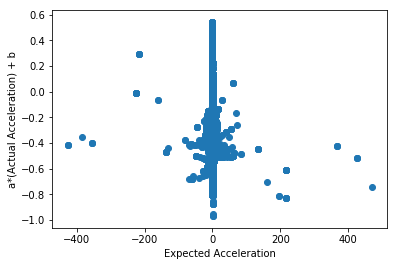

In [15]:
mini_batch = 20000
Rr_batch = np.zeros((mini_batch, No, Nr), dtype=float)
Rs_batch = np.zeros((mini_batch, No, Nr), dtype=float)
Ra_batch = np.zeros((mini_batch, Dr, Nr), dtype=float) 
X_batch = np.zeros((mini_batch, Dx, No), dtype=float)

# add relations for different nodes
count = 0
for i in range(No):
    for j in range(No):
        if i==j: continue
        Rr_batch[:, i, count] = 1.0
        Rs_batch[:, j, count] = 1.0
        count += 1

rand_idx = np.random.randint(0, len(train_data), size=mini_batch)

out_B, out_E, out_P = sess.run([B, E, P],
                        feed_dict = {O: train_data[rand_idx], Rr:Rr_batch, Rs:Rs_batch,
                                     Ra:Ra_batch, P_label: train_label[rand_idx],
                                     X:X_batch, prob:0.0})

out_B = np.transpose(out_B, [0, 2, 1])
out_B = np.reshape(out_B, [-1, 2*Ds+Dr])[:, :-1] #Don't care about 0 element
out_E = np.transpose(out_E, [0, 2, 1])
out_E = np.reshape(out_E, [-1, De])
import pandas as pd
out_data = pd.DataFrame({   'm1': out_B[:, 0],
    'm2': out_B[:, 0+5],
    'x_diff': out_B[:, 1] - out_B[:, 1+5],
    'y_diff': out_B[:, 2] - out_B[:, 2+5],
    'output1': out_E[:, 0],
    'output2': out_E[:, 1]
})
out_data['r'] = np.sqrt(out_data['x_diff']**2 + out_data['y_diff']**2)
out_data.to_csv('tmp_data.csv')

x = out_B #(m, x, y, vx, vy) * 2
sign_idx = 2 #1 or 2
if cube:
    x = (x[:, 5] / ((x[:, 1] - x[:, 1+5])**2 + (x[:, 2] - x[:, 2+5])**3)) * np.sign((x[:, sign_idx] - x[:, sign_idx+5]))
else:
    if inv:
        x = (x[:, 5] / ((x[:, 1] - x[:, 1+5])**2 + (x[:, 2] - x[:, 2+5])**2)**(0.5)) * np.sign((x[:, sign_idx] - x[:, sign_idx+5]))
    else:
        x = (x[:, 5] / ((x[:, 1] - x[:, 1+5])**2 + (x[:, 2] - x[:, 2+5])**2)) * np.sign((x[:, sign_idx] - x[:, sign_idx+5]))

    
y = out_E[:, 1]

plt.scatter(x, y)
plt.xlabel("Expected Acceleration")
plt.ylabel("a*(Actual Acceleration) + b")

Test MSE: 0.6508233075141907


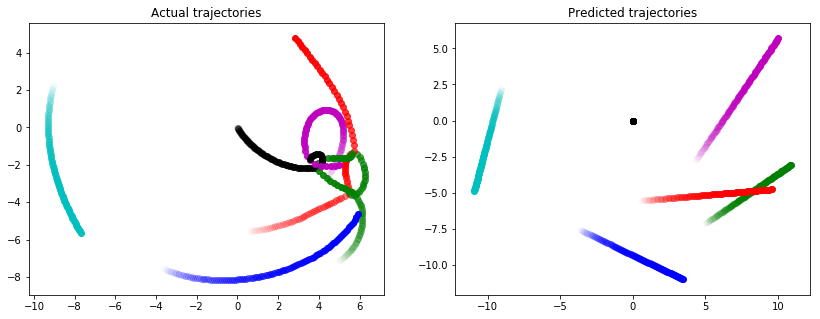

In [17]:
# Make Prediction

raw_data = get_simulation(No)
here_Nt = 1000
predict = np.zeros((here_Nt, No, Ds),dtype=float)

ts_loss, predict[0] = 0.0, raw_data[0]
predict[0, :, 3:5] = predict[0, :, 3:5]# * (std_label[None, :] / LABEL_MAGIC)
for i in range(1, here_Nt):
    loss, vel_difference = sess.run(
        [mse, P],
        feed_dict={
            O:[np.transpose(predict[i-1])], Rr:[Rr_batch[0]],
            Rs:[Rs_batch[0]], Ra:[Ra_batch[0]],
            X:[X_batch[0]],
            P_label:[np.transpose(raw_data[i,:,3:5])], prob: 0.0}
    )
    #Update velocity
    
    #IM AN IDIOT - I NEED TO INCLUDE VEL DIFFERENCES FOR ALL BODIES!
    predict[i, :, 3:5] = predict[i-1, :, 3:5] + vel_difference[0].T * (1. / LABEL_MAGIC)
    
    predict[i, :, 1:3] = predict[i-1,:,1:3] + predict[i, :, 3:5]*Dt #Update position

    ts_loss += loss 
print("Test MSE: "+ str(ts_loss/(here_Nt)))
colors = ['k','r','g','b','c','m']

# Plot actual and predicted trajectories
fig, ax = plt.subplots(1,2,figsize=(14,5))
for i in range(here_Nt):
    if i%10 != 0: continue
    for j in range(raw_data.shape[1]):
        ax[0].scatter(raw_data[i,j,1], raw_data[i,j,2], color=colors[j%len(colors)], alpha=(i/len(raw_data)))
        ax[1].scatter(predict[i,j,1], predict[i,j,2], color=colors[j%len(colors)], alpha=(i/len(raw_data)))

ax[0].set_title("Actual trajectories")
ax[1].set_title("Predicted trajectories")
plt.show()

In [19]:
# Make Prediction
raw_data = get_simulation(No)
predict = np.zeros((Nt, No, Ds),dtype=float)

ts_loss = 0
predict[0] = raw_data[0]
for i in range(1,Nt):
    loss, vel = sess.run([mse, P], feed_dict={O:[np.transpose(raw_data[i-1])], Rr:[Rr_data[0]],
        Rs:[Rs_data[0]], Ra:[Ra_data[0]],X:[X_data[0]], P_label:[np.transpose(raw_data[i,:,3:5])]})
    predict[i,:,3:5] = np.transpose(vel[0])
    predict[i,:,1:3] = predict[i-1,:,1:3] + predict[i,:,3:5]*Dt
    ts_loss += loss 
print("Test MSE: "+ str(ts_loss))

NameError: name 'Rr_data' is not defined

In [ ]:
# Plot actual and predicted trajectories
colors = ['k','r','g','b','c','m']
fig, ax = plt.subplots(1,2,figsize=(14,5))
for i in range(len(raw_data)):
    if i%10 != 0: continue
    for j in range(raw_data.shape[1]):
        ax[0].scatter(raw_data[i,j,1], raw_data[i,j,2], color=colors[j%len(colors)])
        ax[1].scatter(predict[i,j,1], predict[i,j,2], color=colors[j%len(colors)])
ax[0].set_title("Actual trajactories")
ax[1].set_title("Predicted trajactories")
plt.show()